<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

###Состав команды

## Микишева Мария гр. Б03-213с
## Берёзкин Фёдор гр. Б03-212и

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_path = "/content/drive/MyDrive/Colab Notebooks/ml_hw4/"

In [3]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from collections import defaultdict
import random
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from torchvision.transforms.functional import to_pil_image



import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Omniglot

import wandb

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    DEVICE = torch.device('cuda')
    print(f"Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    DEVICE = torch.device('cpu')
    print("No GPU found, running on CPU")

np.random.seed(42)

Running on GPU: Tesla T4


In [5]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [6]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-06-02 08:52:27--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-06-02 08:52:28--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  17.0MB/s    in 0.4s    

2025-06-02 08:52:29 (17.0 MB/s) - ‘images_evaluation.zip’ saved 

In [7]:

!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [8]:
def read_alphabets(alphabet_directory_path, alphabet_name):
    datax = []
    datay = []
    metay = []

    for character in os.listdir(alphabet_directory_path):
        char_path = os.path.join(alphabet_directory_path, character)
        if not os.path.isdir(char_path):
            continue

        for img_file in os.listdir(char_path):
            if not img_file.endswith(".png"):
                continue

            img_path = os.path.join(char_path, img_file)
            img = Image.open(img_path).convert('RGB')

            for angle, suffix in zip([0, 90, 180, 270], ["rot0", "rot90", "rot180", "rot270"]):
                rotated_img = img.rotate(angle, expand=True)
                datax.append(np.array(rotated_img))
                datay.append(f"{alphabet_name}/{character}")  # Без суффикса
                metay.append(suffix)

    return datax, datay, metay

In [9]:
def read_images(base_directory):
    datax, datay, metay = [], [], []

    for directory in os.listdir(base_directory):
        alphabet_path = os.path.join(base_directory, directory)
        if not os.path.isdir(alphabet_path):
            continue
        dx, dy, dmeta = read_alphabets(alphabet_path, directory)
        datax.extend(dx)
        datay.extend(dy)
        metay.extend(dmeta)

    return datax, datay, metay

In [10]:
trainx, trainy, metay = read_images('images_background')
testx, testy, testmeta = read_images('images_evaluation')

In [13]:
print(len(trainx), len(trainy), len(testx), len(testy))

77120 77120 52720 52720


In [14]:
print("Уникальных классов в trainy:", len(np.unique(trainy)))

Уникальных классов в trainy: 964


In [15]:
print(len(np.unique(testy)))

659


## Mini EDA

In [16]:
#  Основная стата
print("═"*40 + "\n Основная статистика\n" + "═"*40)
print(f"Обучающая выборка: {len(trainx)} примеров, {len(np.unique(trainy))} классов")
print(f"Тестовая выборка: {len(testx)} примеров, {len(np.unique(testy))} классов")
print(f"Размер изображений: {trainx[0].shape}")

════════════════════════════════════════
 Основная статистика
════════════════════════════════════════
Обучающая выборка: 77120 примеров, 964 классов
Тестовая выборка: 52720 примеров, 659 классов
Размер изображений: (105, 105, 3)


In [17]:
#  Анализ алфавитов
def parse_metadata(labels):
    alphabets = []
    characters = []
    rotations = []

    for label in labels:
        parts = label.split('/')
        alphabet = parts[0]
        char_rot = parts[1].split('_')
        char = '_'.join(char_rot[:-1])
        rotation = char_rot[-1]

        alphabets.append(alphabet)
        characters.append(char)
        rotations.append(rotation)

    return pd.DataFrame({
        'alphabet': alphabets,
        'character': characters,
        'rotation': rotations
    })

In [18]:
train_df = parse_metadata(trainy)
test_df = parse_metadata(testy)

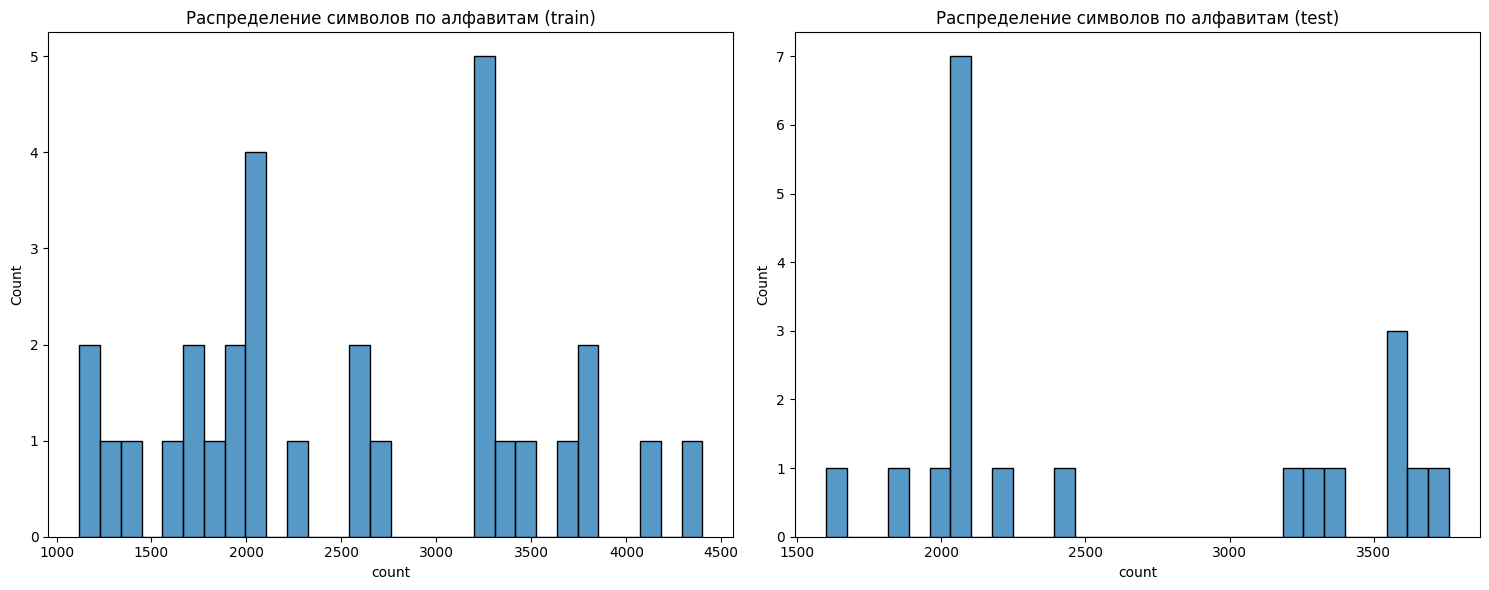

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(train_df['alphabet'].value_counts(), bins=30)
plt.title('Распределение символов по алфавитам (train)')

plt.subplot(1,2,2)
sns.histplot(test_df['alphabet'].value_counts(), bins=30)
plt.title('Распределение символов по алфавитам (test)')
plt.tight_layout()
plt.show()

In [20]:
print("\n Топ-5 алфавитов:")
print(pd.DataFrame({
    'Train': dict(Counter(train_df['alphabet']).most_common(5)),
    'Test': dict(Counter(test_df['alphabet']).most_common(5))
}).fillna('-'))


 Топ-5 алфавитов:
                                 Train    Test
Tifinagh                        4400.0       -
Japanese_(hiragana)             4160.0       -
Gujarati                        3840.0       -
Japanese_(katakana)             3760.0       -
Bengali                         3680.0       -
Malayalam                            -  3760.0
Oriya                                -  3680.0
Old_Church_Slavonic_(Cyrillic)       -  3600.0
Glagolitic                           -  3600.0
Gurmukhi                             -  3600.0


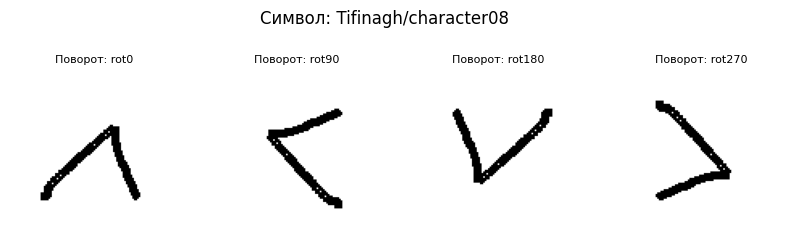

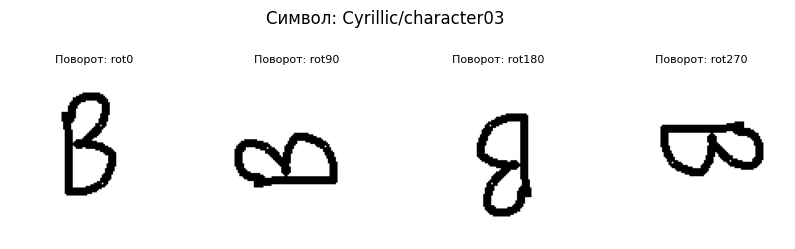

In [21]:
def plot_rotations(alphabet, character):
    base_class = f"{alphabet}/{character}"
    suffixes = ["rot0", "rot90", "rot180", "rot270"]

    plt.figure(figsize=(10, 3))
    for i, suffix in enumerate(suffixes):
        idx = [j for j in range(len(trainy)) if trainy[j] == base_class and metay[j] == suffix]
        if not idx:
            print(f"Не найдено изображение для {base_class} с поворотом {suffix}")
            continue
        idx = idx[0]

        plt.subplot(1, 4, i + 1)
        plt.imshow(trainx[idx])
        plt.title(f"Поворот: {suffix}", fontsize=8)
        plt.axis('off')

    plt.suptitle(f"Символ: {alphabet}/{character}")
    plt.show()

plot_rotations('Tifinagh', 'character08')
plot_rotations('Cyrillic', 'character03')

In [53]:
def plot_alphabet_samples(alphabet, n=5):
    alphabet_idx = np.where(train_df['alphabet'] == alphabet)[0]
    samples = np.random.choice(alphabet_idx, n, replace=False)

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(samples):
        plt.subplot(1,n,i+1)
        plt.imshow(trainx[idx])
        plt.title(f"{trainy[idx].split('_')[-1]}", fontsize=8)
        plt.axis('off')
    plt.suptitle(f"Алфавит: {alphabet}")
    plt.show()

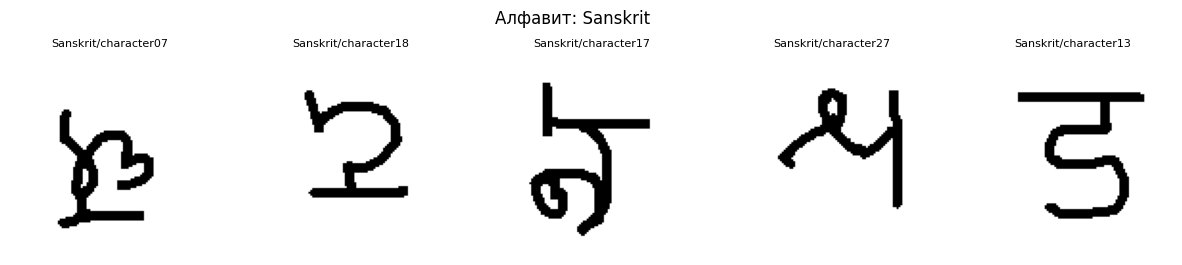

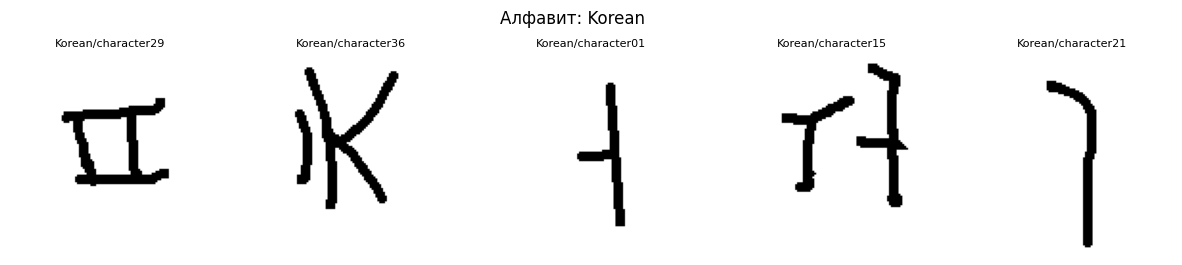

In [54]:
plot_alphabet_samples('Sanskrit')
plot_alphabet_samples('Korean')

## Create samples

In [22]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample_images = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)

    for cls in K:
        idxs = [i for i, y in enumerate(datay) if y == cls]
        selected = np.random.choice(idxs, n_support + n_query, replace=False)
        images = [cv2.resize(datax[i], (28, 28)) for i in selected]
        sample_images.append(images)

    sample = torch.tensor(np.array(sample_images)).float()
    sample = sample.permute(0, 1, 4, 2, 3)  # (n_way, n_shot, C, H, W)

    return {
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    }

In [23]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    out = out.permute(1, 2, 0).numpy() / 255.0

    plt.figure(figsize=(16, 7))
    plt.imshow(out)

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

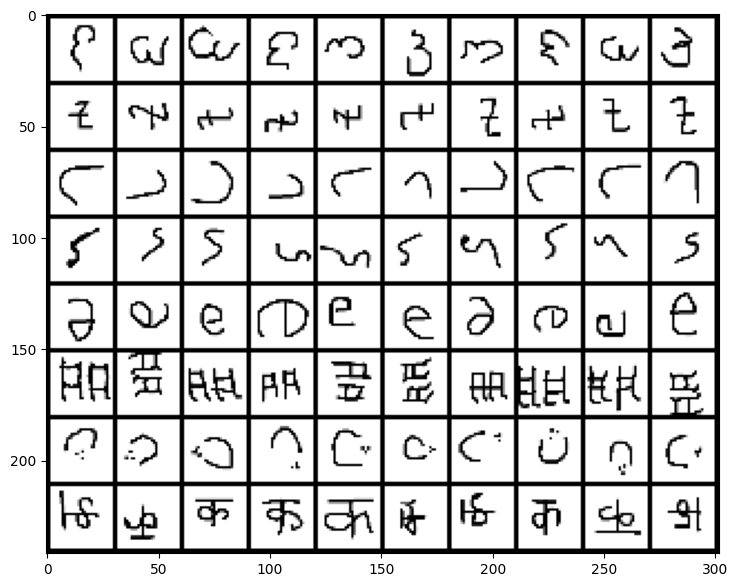

In [61]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [62]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64)
        )

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

In [64]:
#провер0чка

#  для batch_size=16
x = torch.randn(16, 3, 28, 28)
encoder = Encoder()
output = encoder(x)
print(output.shape)


torch.Size([16, 64])


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [25]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder.to(self.device)

    def set_forward_loss(self, sample):
        sample_images = sample['images'].to(self.device)
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_dim = sample_images.size(2)  # channels (3)
        sample_images = sample_images.view(n_way, n_support + n_query, x_dim, 28, 28)

        support = sample_images[:, :n_support].contiguous().view(-1, x_dim, 28, 28)
        query = sample_images[:, n_support:].contiguous().view(-1, x_dim, 28, 28)

        z_support = self.encoder(support)
        z_query = self.encoder(query)

        z_proto = z_support.view(n_way, n_support, -1).mean(1)

        dists = self.euclidean_dist(z_query, z_proto)
        log_p_y = F.log_softmax(-dists, dim=1)
        y_query = torch.repeat_interleave(torch.arange(n_way), n_query).to(self.device)

        loss = F.nll_loss(log_p_y, y_query)
        acc = (log_p_y.argmax(dim=1) == y_query).float().mean()

        return loss, {'loss': loss.item(), 'acc': acc.item(), 'y_hat': log_p_y.argmax(dim=1)}

    @staticmethod
    def euclidean_dist(x, y):
        return torch.cdist(x, y, p=2).pow(2)

In [26]:
def load_protonet_conv(**kwargs):
    class Encoder(nn.Module):
        def __init__(self, input_dim=3, hid_dim=64, z_dim=64):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(input_dim, hid_dim, 3, padding=1),
                nn.BatchNorm2d(hid_dim),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(hid_dim, hid_dim, 3, padding=1),
                nn.BatchNorm2d(hid_dim),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(hid_dim, hid_dim, 3, padding=1),
                nn.BatchNorm2d(hid_dim),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(hid_dim, z_dim, 3, padding=1),
                nn.BatchNorm2d(z_dim),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            )

        def forward(self, x):
            return self.net(x).flatten(1)

    return ProtoNet(Encoder(**kwargs))

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [27]:
n_way = 60
n_support = 5
n_query = 5

In [28]:
pip install wandb

In [29]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mikisevam (mikisevam-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## версия train с dual-логированием

In [30]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    train_loss_history = []
    train_acc_history = []

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc=f"Epoch {epoch+1} train"):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size

        # ручное логирование
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # wandb логирование
        wandb.log({
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "epoch": epoch + 1
        })

        print(f"Epoch {epoch+1} -- Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        epoch += 1
        scheduler.step()

    return train_loss_history, train_acc_history

In [31]:
wandb.init(project="protonet-omniglot", name="proto-run")

In [126]:
model = load_protonet_conv(
    input_dim=3,
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [127]:
print(f"Количество уникальных классов в train_y: {len(np.unique(trainy))}")
print(f"n_way = {n_way}")

Количество уникальных классов в train_y: 3856
n_way = 60


In [128]:
import os

save_path = "/content/drive/MyDrive/Colab Notebooks/ml_hw4/"
os.makedirs(save_path + "models", exist_ok=True)

In [129]:
os.makedirs(save_path+"report", exist_ok=True)

In [130]:
%%time

train_loss, train_acc = train(
    model, optimizer, train_x, train_y,
    n_way=60, n_support=5, n_query=5,
    max_epoch=5, epoch_size=2000
)

torch.save(model.state_dict(), save_path+"models/protonet_model.pt")

Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1126 Acc: 0.9670


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0411 Acc: 0.9854


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0315 Acc: 0.9883


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0268 Acc: 0.9896


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0237 Acc: 0.9909
CPU times: user 25min 40s, sys: 22.8 s, total: 26min 3s
Wall time: 16min 18s


In [131]:
torch.save(model.state_dict(), save_path + "models/protonet_model.pt")

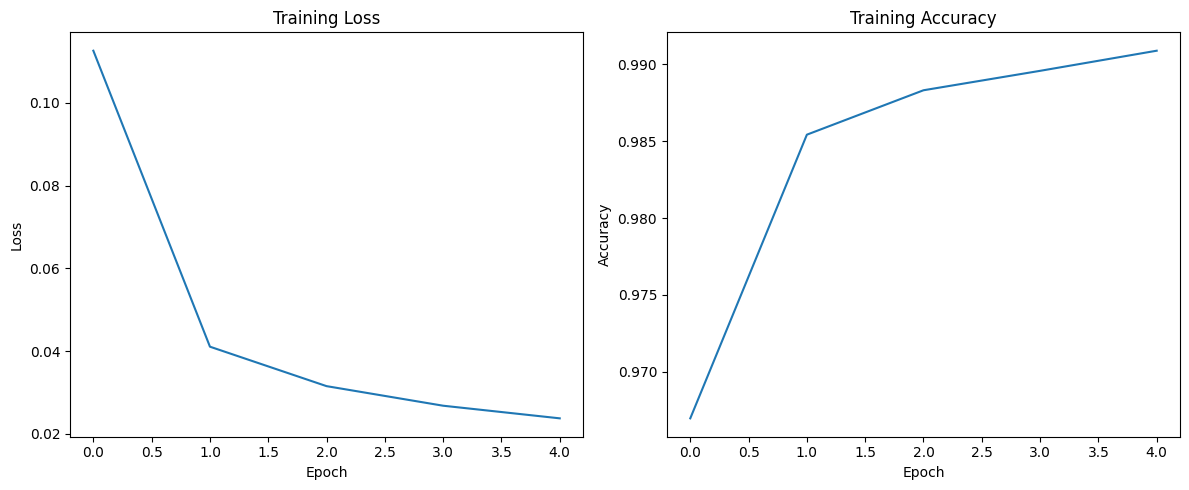

In [132]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig(save_path+"report/plots.png")
plt.show()

## Test

In [32]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    with torch.no_grad():
        for episode in tnrange(test_episode):
            sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode

    wandb.log({
        "test_loss": avg_loss,
        "test_accuracy": avg_acc
    })

    print(f'Test results -- Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

In [134]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [135]:
model = load_protonet_conv().to(device)
model.load_state_dict(torch.load(save_path + "models/protonet_model.pt", map_location=device))
model.eval()

ProtoNet(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.

In [136]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0165 Acc: 0.9964


(0.01653063908974086, 0.9963999980688095)

## Test on specific example

In [137]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)

Shape: torch.Size([5, 10, 3, 28, 28]) — (n_way, n_support+n_query, C, H, W)
n_way = 5, n_support = 5, n_query = 5


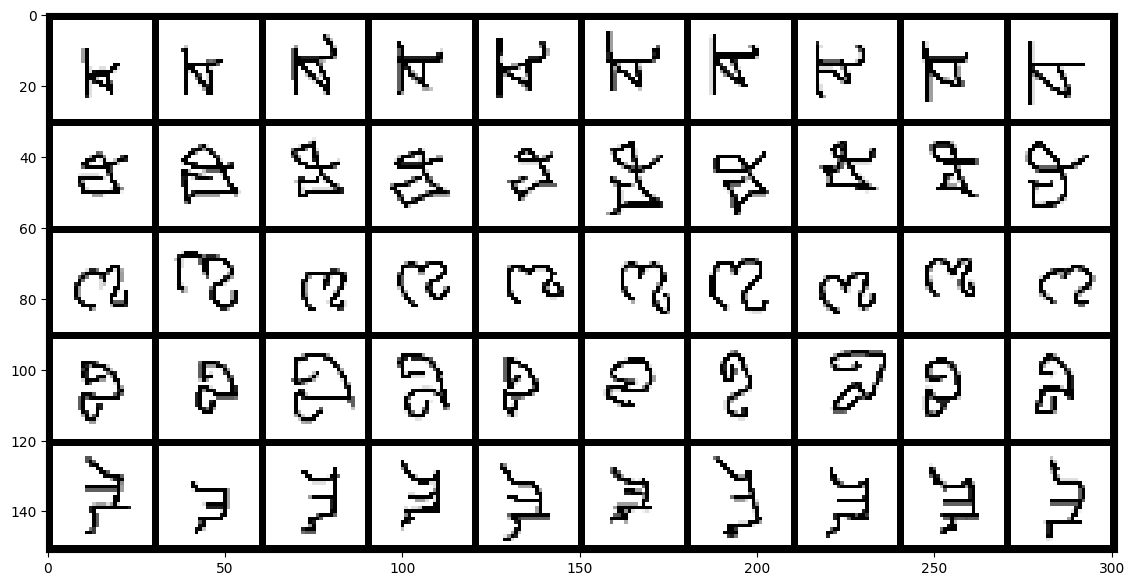

In [138]:
print(f"Shape: {my_sample['images'].shape} — (n_way, n_support+n_query, C, H, W)")
print(f"n_way = {n_way}, n_support = {n_support}, n_query = {n_query}")
display_sample(my_sample['images'])

In [139]:
loss, output = model.set_forward_loss(my_sample)
print(f"Predicted labels: {output['y_hat'].cpu().numpy()}")

Predicted labels: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [140]:
save_path1 = "/content/drive/MyDrive/Colab Notebooks/ml_hw4/predictions/sample_predictions.txt"
os.makedirs(os.path.dirname(save_path1), exist_ok=True)

In [98]:
def predict_and_visualize(model, test_x, test_y, n_way=5, n_support=5, n_query=1, save_path1=save_path+"predictions/sample_predictions.txt"):
    os.makedirs("predictions", exist_ok=True)
    lines = []

    for idx in range(10):  # 10 эпизодов
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        images = sample['images']
        display_sample(images)

        loss, output = model.set_forward_loss(sample)
        preds = output['y_hat'].cpu().numpy()
        true = np.tile(np.arange(n_way), n_query)

        print(f"Episode {idx}:")
        lines.append(f"[Episode {idx}]")
        for i in range(n_way * n_query):
            print(f"  Image {i}: predicted = {preds[i]}, true = {true[i]}")
            lines.append(f"  Predicted: {preds[i]} | Reference: {true[i]}")
        lines.append("")

    with open(save_path1, "w") as f:
        f.write("\n".join(lines))

    print(f"Predictions saved to {save_path1}")

Episode 0:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1, true = 1
  Image 2: predicted = 2, true = 2
  Image 3: predicted = 3, true = 3
  Image 4: predicted = 4, true = 4
Episode 1:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1, true = 1
  Image 2: predicted = 2, true = 2
  Image 3: predicted = 3, true = 3
  Image 4: predicted = 4, true = 4
Episode 2:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1, true = 1
  Image 2: predicted = 2, true = 2
  Image 3: predicted = 3, true = 3
  Image 4: predicted = 4, true = 4
Episode 3:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1, true = 1
  Image 2: predicted = 2, true = 2
  Image 3: predicted = 3, true = 3
  Image 4: predicted = 4, true = 4
Episode 4:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1, true = 1
  Image 2: predicted = 2, true = 2
  Image 3: predicted = 3, true = 3
  Image 4: predicted = 4, true = 4
Episode 5:
  Image 0: predicted = 0, true = 0
  Image 1: predicted = 1

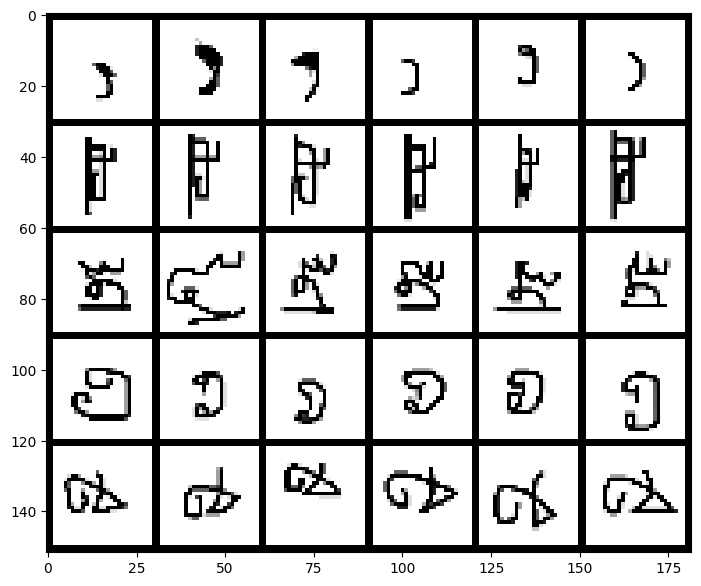

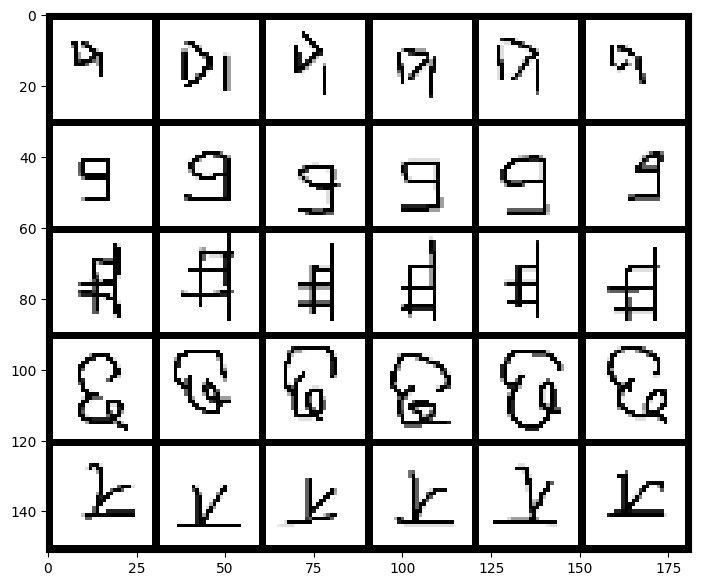

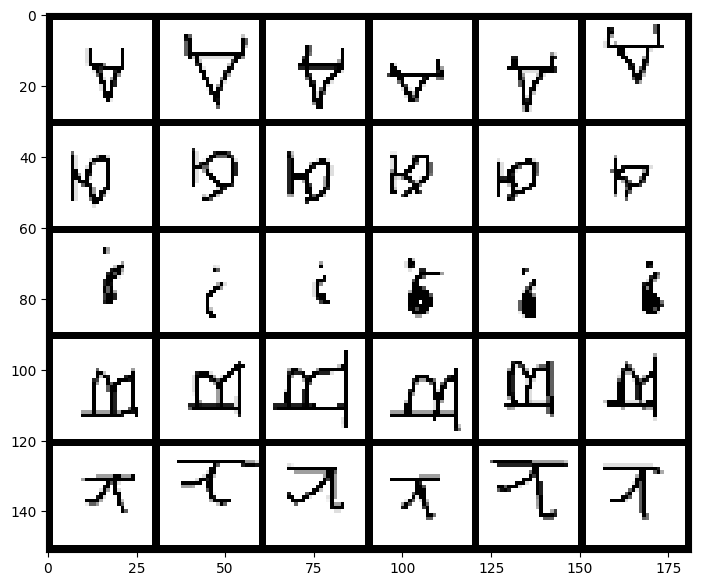

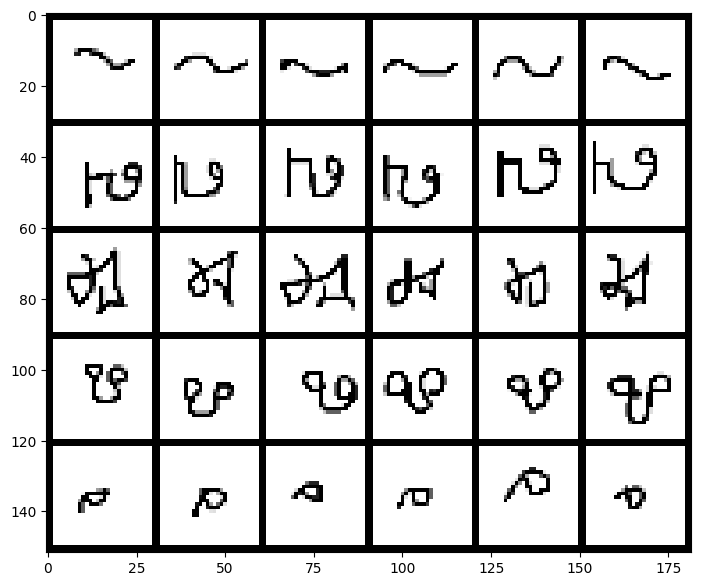

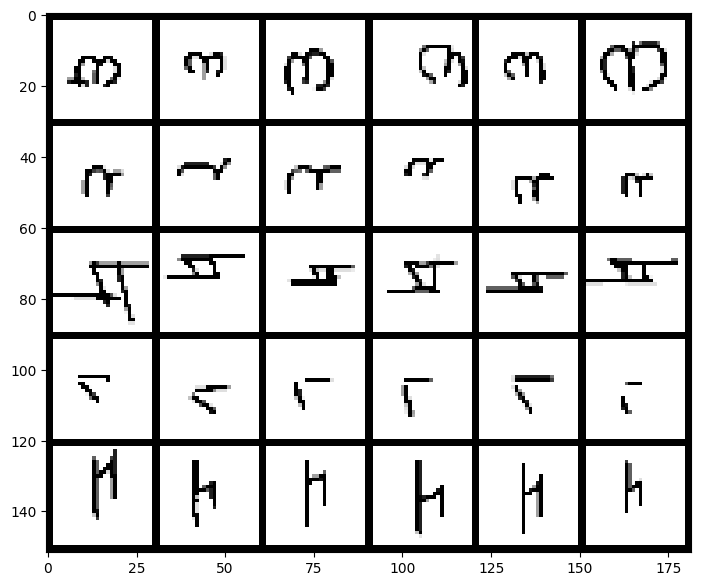

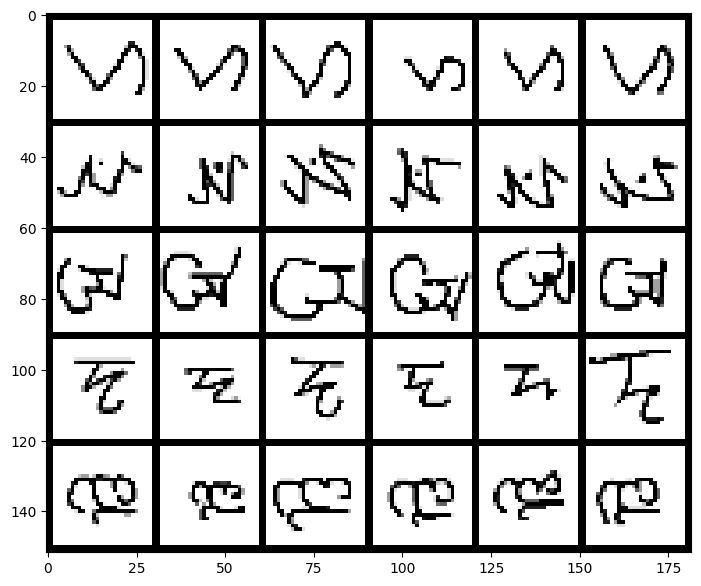

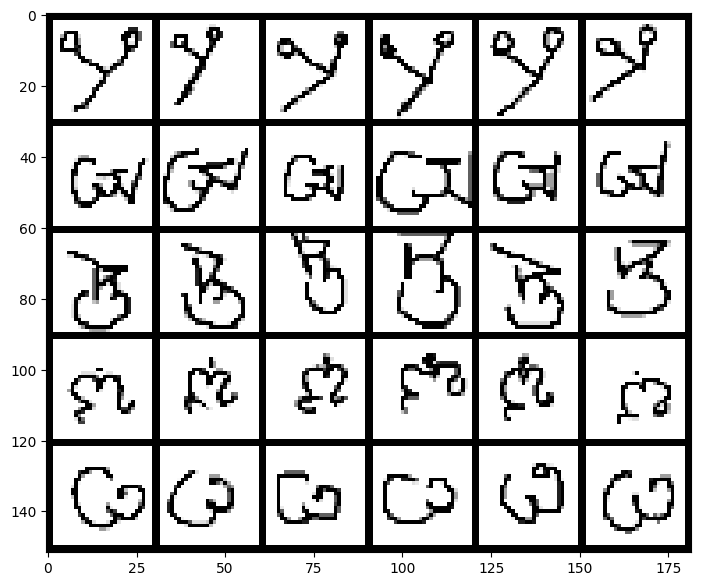

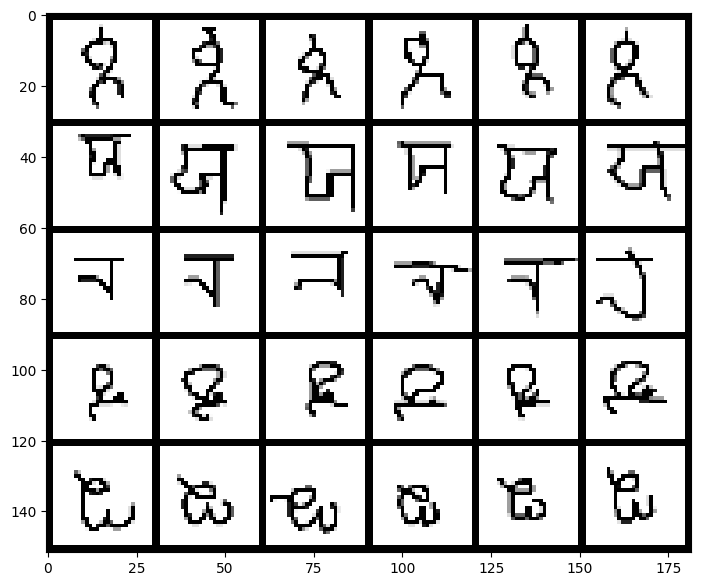

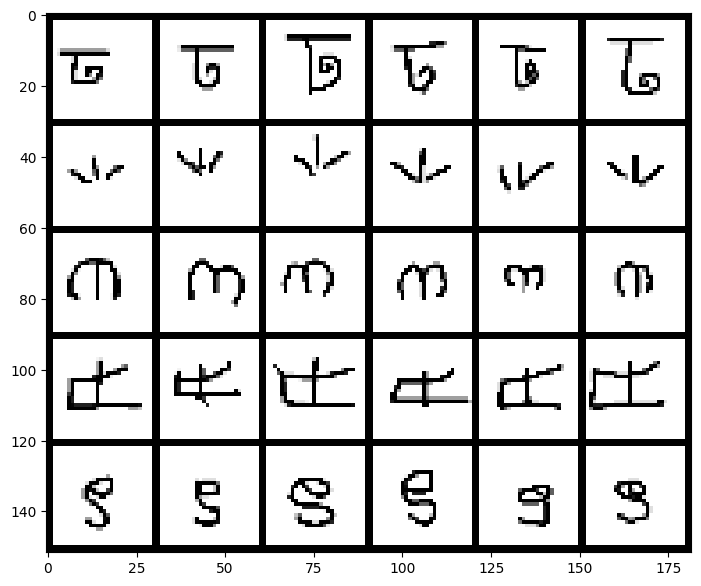

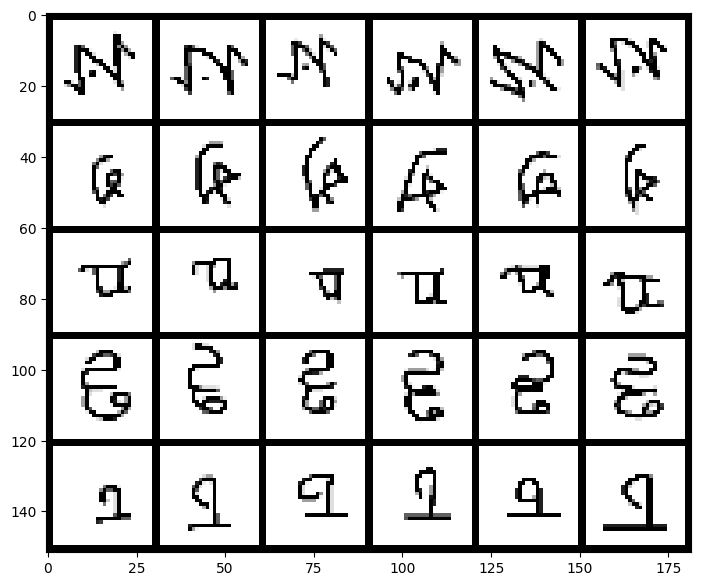

In [99]:
predict_and_visualize(model, testx, testy, n_way=5, n_support=5, n_query=1)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара



In [47]:
save_path = SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/ml_hw4/"

In [50]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
from torch.utils.data import Dataset

class TwoAugDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

In [52]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

clf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [53]:
cifar_raw = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None  # Без преобразований!
)

In [54]:
simclr_augmented = TwoAugDataset(cifar_raw, simclr_transform)

clf_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=clf_transform
)
clf_train, clf_val = random_split(clf_dataset, [8000, 2000])

In [55]:
simclr_loader = DataLoader(
    simclr_augmented,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

clf_train_loader = DataLoader(
    clf_train,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

clf_val_loader = DataLoader(
    clf_val,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [56]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, hid_dim=512, out_dim=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        return F.normalize(self.proj(x), dim=1)

class SimCLRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.resnet18(weights=None)
        self.encoder.fc = nn.Identity()
        self.projector = ProjectionHead()

    def forward(self, x):
        features = self.encoder(x)
        return self.projector(features)

In [57]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size

        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = torch.ones((N, N), dtype=bool, device=z.device)
        mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        positives = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negatives = sim[mask].reshape(N, -1)

        logits = torch.cat((positives, negatives), dim=1)
        labels = torch.zeros(N, dtype=torch.long, device=z.device)

        loss = self.criterion(logits, labels) / N
        return loss

In [58]:
def train_simclr():
    model = SimCLRModel().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = SimCLR_Loss(temperature=0.5).to(DEVICE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

    cifar_train = datasets.CIFAR10(
        root=os.path.join(SAVE_PATH, "data"),
        train=True,
        download=True,
        transform=None
    )
    train_loader = DataLoader(
        TwoAugDataset(cifar_train, simclr_transform),
        batch_size=256,
        shuffle=True,
        drop_last=True
    )

    wandb.init(project="simclr-cifar10", config={
        "epochs": 100,
        "batch_size": 256,
        "lr": 3e-4
    })

    best_loss = float('inf')
    loss_history = []
    for epoch in range(100):
        model.train()
        total_loss = 0

        for x1, x2 in train_loader:
            x1, x2 = x1.to(DEVICE), x2.to(DEVICE)

            optimizer.zero_grad()
            z_i = model(x1)
            z_j = model(x2)
            loss = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        loss_history.append(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(SAVE_PATH, "models/simclr_best.pth"))

        wandb.log({"epoch": epoch+1, "loss": avg_loss})
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

    plt.figure(figsize=(10,5))
    plt.plot(loss_history)
    plt.title("SimCLR Training Loss")
    plt.savefig(os.path.join(SAVE_PATH, "results/simclr_loss.png"))

    pd.DataFrame({"epoch": range(1, len(loss_history)+1), "loss": loss_history}).to_csv(
        os.path.join(SAVE_PATH, "results/simclr_log.csv"), index=False
    )

    wandb.finish()
    return model

In [127]:
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x)
        out = self.classifier(h)
        return out

In [59]:
def train_classifier():
    model = SimCLRModel().to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(SAVE_PATH, "models/simclr_best.pth")))

    clf_dataset = datasets.CIFAR10(
        root=os.path.join(SAVE_PATH, "data"),
        train=False,
        download=True,
        transform=clf_transform
    )
    clf_train, clf_val = random_split(clf_dataset, [8000, 2000])
    train_loader = DataLoader(clf_train, batch_size=128, shuffle=True)
    val_loader = DataLoader(clf_val, batch_size=128, shuffle=False)

    clf_model = DownstreamClassifier(model.encoder).to(DEVICE)
    optimizer = torch.optim.Adam(clf_model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    wandb.init(project="downstream-classification")

    best_acc = 0.0
    for epoch in range(20):
        clf_model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            out = clf_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        val_acc = evaluate(clf_model, val_loader)
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(clf_model.state_dict(), os.path.join(SAVE_PATH, "models/best_clf.pth"))

        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f} | Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")

    wandb.finish()
    return clf_model, val_loader

In [60]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

Начало обучения SimCLR


100%|██████████| 170M/170M [00:34<00:00, 4.89MB/s]


Epoch 1: Loss 5.3934
Epoch 2: Loss 5.2087
Epoch 3: Loss 5.1344
Epoch 4: Loss 5.0995
Epoch 5: Loss 5.0728
Epoch 6: Loss 5.0536
Epoch 7: Loss 5.0300
Epoch 8: Loss 5.0155
Epoch 9: Loss 5.0052
Epoch 10: Loss 4.9886
Epoch 11: Loss 4.9791
Epoch 12: Loss 4.9656
Epoch 13: Loss 4.9574
Epoch 14: Loss 4.9516
Epoch 15: Loss 4.9376
Epoch 16: Loss 4.9300
Epoch 17: Loss 4.9238
Epoch 18: Loss 4.9155
Epoch 19: Loss 4.9106
Epoch 20: Loss 4.9038
Epoch 21: Loss 4.8997
Epoch 22: Loss 4.8934
Epoch 23: Loss 4.8901
Epoch 24: Loss 4.8837
Epoch 25: Loss 4.8798
Epoch 26: Loss 4.8777
Epoch 27: Loss 4.8674
Epoch 28: Loss 4.8667
Epoch 29: Loss 4.8640
Epoch 30: Loss 4.8577
Epoch 31: Loss 4.8590
Epoch 32: Loss 4.8532
Epoch 33: Loss 4.8489
Epoch 34: Loss 4.8468
Epoch 35: Loss 4.8437
Epoch 36: Loss 4.8404
Epoch 37: Loss 4.8400
Epoch 38: Loss 4.8367
Epoch 39: Loss 4.8341
Epoch 40: Loss 4.8286
Epoch 41: Loss 4.8263
Epoch 42: Loss 4.8252
Epoch 43: Loss 4.8233
Epoch 44: Loss 4.8226
Epoch 45: Loss 4.8189
Epoch 46: Loss 4.81

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ml_hw4/results/simclr_loss.png'

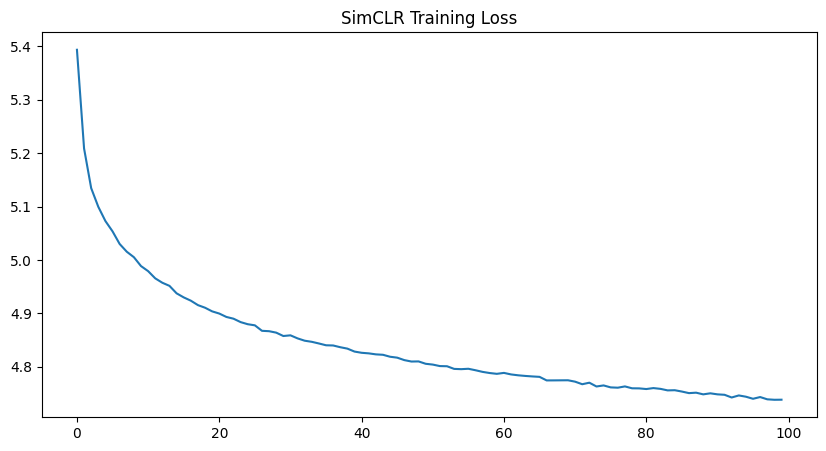

In [61]:
print("="*50)
print("Начало обучения SimCLR")
simclr_model = train_simclr()

In [62]:
results_path = "./results"
os.makedirs(results_path, exist_ok=True)
plt.savefig(os.path.join(results_path, "simclr_loss.png"))

<Figure size 640x480 with 0 Axes>

In [64]:
print("\n" + "="*50)
print("Начало обучения классификатора")
clf_model, val_loader = train_classifier()


Начало обучения классификатора


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,4.73849


Epoch 1: Loss 1.2085 | Train Acc 0.5740 | Val Acc 0.6395
Epoch 2: Loss 0.9856 | Train Acc 0.6501 | Val Acc 0.6390
Epoch 3: Loss 0.9636 | Train Acc 0.6556 | Val Acc 0.6470
Epoch 4: Loss 0.9286 | Train Acc 0.6689 | Val Acc 0.6530
Epoch 5: Loss 0.9181 | Train Acc 0.6725 | Val Acc 0.6555
Epoch 6: Loss 0.9030 | Train Acc 0.6796 | Val Acc 0.6655
Epoch 7: Loss 0.8966 | Train Acc 0.6831 | Val Acc 0.6625
Epoch 8: Loss 0.8890 | Train Acc 0.6811 | Val Acc 0.6620
Epoch 9: Loss 0.8864 | Train Acc 0.6846 | Val Acc 0.6625
Epoch 10: Loss 0.8702 | Train Acc 0.6900 | Val Acc 0.6655
Epoch 11: Loss 0.8672 | Train Acc 0.6867 | Val Acc 0.6790
Epoch 12: Loss 0.8725 | Train Acc 0.6841 | Val Acc 0.6700
Epoch 13: Loss 0.8481 | Train Acc 0.6924 | Val Acc 0.6635
Epoch 14: Loss 0.8544 | Train Acc 0.6986 | Val Acc 0.6715
Epoch 15: Loss 0.8423 | Train Acc 0.6970 | Val Acc 0.6660
Epoch 16: Loss 0.8412 | Train Acc 0.6969 | Val Acc 0.6755
Epoch 17: Loss 0.8359 | Train Acc 0.6993 | Val Acc 0.6655
Epoch 18: Loss 0.8295 |

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▅▅▆▆▇▇▇▇▇▇▇▇█▇▇████
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
val_acc,▁▁▂▃▄▆▅▅▅▆█▆▅▇▆▇▆▆▆▆
epoch,20
train_acc,0.7035
train_loss,0.82764
val_acc,0.67


In [65]:
clf_model.load_state_dict(torch.load(os.path.join(SAVE_PATH, "models/best_clf.pth")))
final_acc = evaluate(clf_model, val_loader)
print("\n" + "="*50)
print(f"Финальная точность на валидации: {final_acc:.4f}")


Финальная точность на валидации: 0.6790


In [67]:
import os

results_dir = os.path.join(SAVE_PATH, "results")
os.makedirs(results_dir, exist_ok=True)

with open(os.path.join(results_dir, "final_acc.txt"), "w") as f:
    f.write(f"Final validation accuracy: {final_acc:.4f}")

In [68]:
with open(os.path.join(SAVE_PATH, "results/final_acc.txt"), "w") as f:
        f.write(f"Final validation accuracy: {final_acc:.4f}")

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [69]:
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            h = self.encoder(x)
        return self.classifier(h)

def evaluate(model, loader, dataset_name="Test", verbose=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if verbose:
        print(f"{dataset_name} Accuracy: {acc:.4f}")
    return acc

In [76]:
from IPython.display import Markdown, display

In [77]:
def compare_methods(trained_clf, test_loader, clf_train_loader):
    results = {}
    logs = []

    results['SimCLR'] = evaluate(trained_clf, test_loader, "SimCLR")

    scratch_model = models.resnet18(weights=None).to(DEVICE)
    scratch_model.fc = nn.Linear(512, 10).to(DEVICE)
    optimizer = torch.optim.Adam(scratch_model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print("\n[Scratch] Обучение ResNet18 с нуля:")
    for epoch in range(20):
        scratch_model.train()
        total_loss = 0
        for x, y in clf_train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = scratch_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(clf_train_loader)
        logs.append({'method': 'Scratch', 'epoch': epoch+1, 'loss': avg_loss})
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

    scratch_model.eval()
    results['Scratch'] = evaluate(scratch_model, test_loader, "Scratch")

    random_encoder = models.resnet18(weights=None)
    random_encoder.fc = nn.Identity()
    for p in random_encoder.parameters():
        p.requires_grad = False

    random_clf = DownstreamClassifier(random_encoder.to(DEVICE)).to(DEVICE)
    optimizer = torch.optim.Adam(random_clf.parameters(), lr=1e-3)

    print("\n[Random] Обучение на случайных признаках:")
    for epoch in range(20):
        random_clf.train()
        total_loss = 0
        for x, y in clf_train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = random_clf(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(clf_train_loader)
        logs.append({'method': 'Random', 'epoch': epoch+1, 'loss': avg_loss})
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

    random_clf.eval()
    results['Random'] = evaluate(random_clf, test_loader, "Random")

    os.makedirs(save_path+"./results", exist_ok=True)

    df_logs = pd.DataFrame(logs)
    df_logs.to_csv(save_path+"./results/training_logs.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.bar(
        results.keys(),
        results.values(),
        color=['#2ecc71', '#3498db', '#e74c3c'],
        edgecolor='black'
    )
    plt.title("Сравнение методов обучения", fontsize=14, pad=20)
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(save_path+"./results/comparison.png", dpi=300, bbox_inches='tight')
    plt.close()

    summary = "| Метод       | Accuracy |\n|-------------|----------|\n"
    for method, acc in results.items():
        summary += f"| {method.ljust(10)} | {acc:.4f}   |\n"

    with open(save_path+"./results/summary.md", "w") as f:
        f.write(summary)

    display(Markdown("### Итоговые результаты"))
    display(Markdown(summary))
    display(Markdown("### Средние потери по методам"))
    display(df_logs.groupby("method").mean().reset_index())

    print("\n Результаты сохранены в папке ./results:")
    print("├── training_logs.csv    # Логи обучения")
    print("├── comparison.png       # График сравнения")
    print("└── summary.md           # Текстовая сводка")

    return results

In [78]:
trained_clf = clf_model  # он обучен!
compare_methods(trained_clf, clf_val_loader, clf_train_loader)

SimCLR Accuracy: 0.7000

[Scratch] Обучение ResNet18 с нуля:
Epoch 1: Loss 1.7705
Epoch 2: Loss 1.3663
Epoch 3: Loss 1.1703
Epoch 4: Loss 0.9619
Epoch 5: Loss 0.7991
Epoch 6: Loss 0.6663
Epoch 7: Loss 0.4996
Epoch 8: Loss 0.4093
Epoch 9: Loss 0.3228
Epoch 10: Loss 0.2525
Epoch 11: Loss 0.2082
Epoch 12: Loss 0.1883
Epoch 13: Loss 0.1678
Epoch 14: Loss 0.1363
Epoch 15: Loss 0.1446
Epoch 16: Loss 0.1201
Epoch 17: Loss 0.0879
Epoch 18: Loss 0.0779
Epoch 19: Loss 0.0780
Epoch 20: Loss 0.0955
Scratch Accuracy: 0.5605

[Random] Обучение на случайных признаках:
Epoch 1: Loss 2.2454
Epoch 2: Loss 2.0218
Epoch 3: Loss 1.9330
Epoch 4: Loss 1.8871
Epoch 5: Loss 1.8552
Epoch 6: Loss 1.8296
Epoch 7: Loss 1.8084
Epoch 8: Loss 1.7822
Epoch 9: Loss 1.7774
Epoch 10: Loss 1.7607
Epoch 11: Loss 1.7502
Epoch 12: Loss 1.7486
Epoch 13: Loss 1.7365
Epoch 14: Loss 1.7298
Epoch 15: Loss 1.7245
Epoch 16: Loss 1.7200
Epoch 17: Loss 1.7145
Epoch 18: Loss 1.7096
Epoch 19: Loss 1.7034
Epoch 20: Loss 1.7058
Random Ac

### Итоговые результаты

| Метод       | Accuracy |
|-------------|----------|
| SimCLR     | 0.7000   |
| Scratch    | 0.5605   |
| Random     | 0.3000   |


### Средние потери по методам

,method,epoch,loss
0,Random,10.5,1.807194
1,Scratch,10.5,0.476163



 Результаты сохранены в папке ./results:
├── training_logs.csv    # Логи обучения
├── comparison.png       # График сравнения
└── summary.md           # Текстовая сводка


{'SimCLR': 0.7, 'Scratch': 0.5605, 'Random': 0.3}

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('method')):
  _plot_series(series, series_name, i)
  fig.legend(title='method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('method')):
  _plot_series(series, series_name, i)
  fig.legend(title='method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('epoch', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('method')):
  _plot_series(series, series_name, i)
  fig.legend(title='method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('method')):
  _plot_series(series, series_name, i)
  fig.legend(title='method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='method', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='loss', y='method', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Вывод
### Анализ:

	•	SimCLR показал наилучшую точность (70%), несмотря на отсутствие размеченных меток на этапе предобучения. Это подчёркивает эффективность contrastive learning для инициализации представлений, которые затем хорошо адаптируются к downstream-задачам с ограниченным числом размеченных данных

	•	Обучение “с нуля” дало точность 56%, что является адекватным результатом для ResNet18 без предобучения, ограниченного количества обучающих примеров (8000) и малого числа эпох (20). Однако оно заметно уступает SimCLR, показывая преимущество предварительного обучения

	•	Модель на случайных признаках достигла лишь 30%, что близко к случайному угадыванию (10 классов → 10%). Это подтверждает, что качественные представления критичны для успешной классификации


# Предобучение через SimCLR позволяет значительно улучшить качество классификации на downstream-задаче по сравнению с обучением с нуля. Это демонстрирует мощь self-supervised learning и обосновывает его применение при ограниченной размеченности данных.


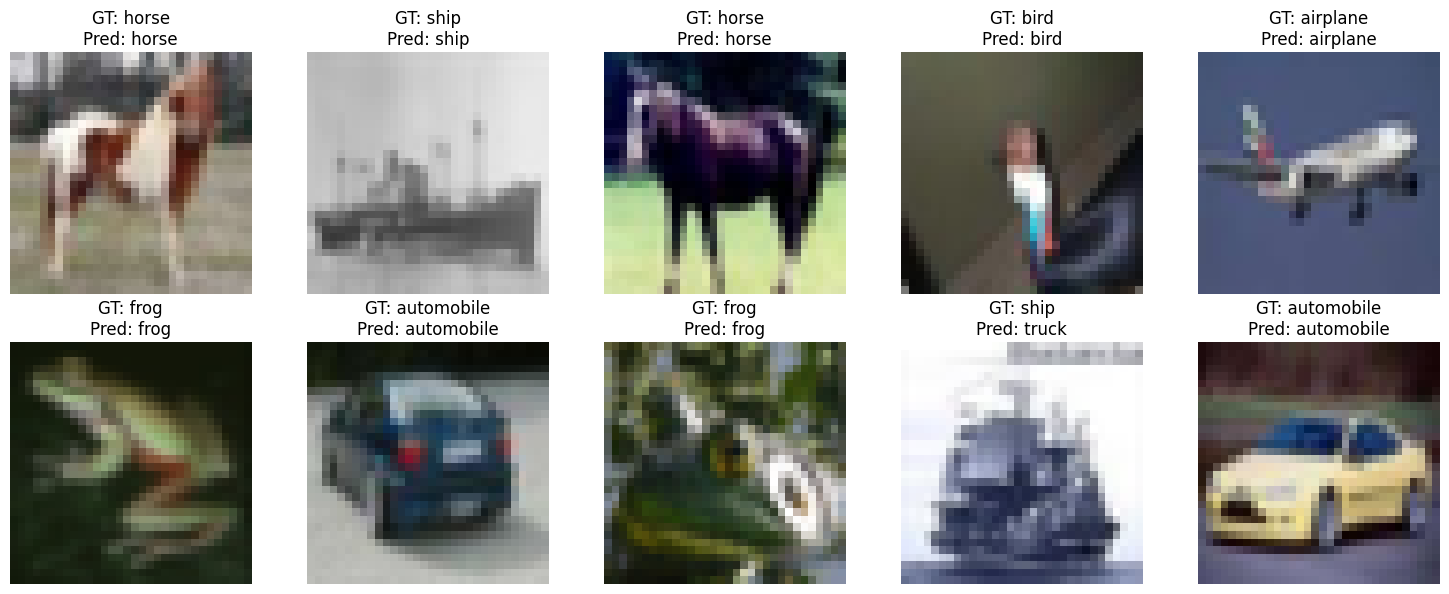

In [95]:
import matplotlib.pyplot as plt
import random

cifar_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def visualize_predictions(model, dataset, device="cuda"):
    model.eval()
    indices = random.sample(range(len(dataset)), 10)
    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()

        plt.subplot(2, 5, i+1)
        img_vis = (img * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(img_vis.permute(1, 2, 0).cpu().numpy())
        plt.title(f"GT: {cifar_classes[label]}\nPred: {cifar_classes[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("./results/sample_predictions.png", dpi=300)
    plt.show()

# Пример вызова:
visualize_predictions(trained_clf, clf_val.dataset)